###### Creating the classes for the DRL algorithm

In [1]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import re
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [2]:
#Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
filepath = './CICIDS2017_preprocessed'
dataset = pd.read_csv(filepath)

In [4]:
dataset.shape

(2830743, 21)

In [5]:
dataset.head()

,Destination Port,Flow Duration,Fwd Packet Length Max,Bwd Packet Length Std,Flow IAT Std,Flow IAT Min,Fwd IAT Mean,Fwd IAT Min,Bwd IAT Mean,Bwd IAT Std,Fwd Packets/s,Packet Length Mean,Packet Length Std,PSH Flag Count,Average Packet Size,Avg Bwd Segment Size,Subflow Fwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Std,Label_binary
0,0.000336,1.491667e-06,0.000000,0.0,0.000000e+00,1.500000e-06,0.000000,9.999999e-08,0.000000e+00,0.0,2.008032e-03,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.004440,0.003723,0.000000,0
1,0.917800,7.999999e-07,0.000000,0.0,1.250775e-07,4.000000e-07,0.000000,9.999999e-08,4.083333e-07,0.0,4.016064e-03,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.003723,0.004440,0.000000,0
2,0.001877,8.329999e-04,0.001934,0.0,0.000000e+00,8.330082e-04,0.000000,9.999999e-08,0.000000e+00,0.0,3.335101e-06,0.014384,0.0,0.0,0.018493,0.008275,0.000000,0.000000,0.000000,0.000000,0
3,0.001877,3.085833e-04,0.001934,0.0,0.000000e+00,3.085916e-04,0.000000,9.999999e-08,0.000000e+00,0.0,9.004872e-06,0.014384,0.0,0.0,0.018493,0.008275,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,9.263445e-01,0.000000,0.0,2.995055e-02,1.166667e-07,0.006345,9.999999e-08,0.000000e+00,0.0,4.408007e-07,0.000000,0.0,0.0,0.000000,0.000000,0.000664,0.000000,0.000000,0.028615,0


In [6]:
Label = dataset['Label_binary']
data = dataset.drop(['Label_binary'], axis=1)
print(data.shape)

(2830743, 20)


# Environment class

In [7]:
class Environment:
    def __init__(self,data, label):
        self.data = data
        self.label = label
        self.action_space = [0,1]
        self.num_actions = len(self.action_space)
        self.last_data_index = len(self.data) - 1
        self.step_count = 0
        self.done = False

    def get_state(self, bs):
        num_states = self.data.shape[0]//bs
        i = np.random.randint(0,num_states)
        indices = range(i*bs, (i+1)*bs)
        state = torch.from_numpy(self.data.loc[indices].to_numpy().astype(np.float32))
        true_label = torch.from_numpy(self.label.loc[indices].to_numpy().astype(np.float32))

        return state, true_label

    def get_reward(self, action, true_label):

        p= action
        t=list(true_label)[0]

        if p==1 and t==1:
            reward = +10 #positive high reward because classification is valid\n",
        elif p==0 and t==1:
            reward = -10 #negative high reward because classification is valid\n",
        elif p==1 and t==0:
            reward = -5 #positive high reward because classification is valid\n",
        else: 
            reward = +5 #positive high reward because classification is valid\n",
        return reward

    def reset(self):
        self.state = 0
        self.done = False
        self.step_count = 0

# DQN Class

In [8]:
class DQN(nn.Module):
    def __init__(self, num_states, num_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = num_states , out_features = 40  )
        self.fc2 = nn.Linear(in_features = 40 , out_features = 40 )
        self.fc3 = nn.Linear(in_features = 40 , out_features = 40 )
        self.out = nn.Linear(in_features = 40 ,out_features = num_actions )
        
    def forward(self, t):
        t = t.flatten(start_dim =1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t
    

# Experience Class

In [9]:
Experience = namedtuple(
        'Experience',
            ('state', 'action', 'next_state', 'reward')
)

# Replay Memory Class

In [10]:
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0  
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] =experience
        self.push_count += 1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon Greedy Strategy

This strategy helps the agent indentify when to exploit and when to explore the environment. This done based on the Epsilon value that we assign. 

We can also implement the Boltzmann strategy which uses a T varibale that decays 

In [11]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

# Reinforcement Learning Agent

In [12]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions) #explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).item() #exploit

# Extract tensors

In [13]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    

    t1= torch.cat(tuple(batch[0]))
    t2= torch.cat(tuple((torch.tensor([batch.action]))))
    t3= torch.cat(tuple((torch.tensor([batch.reward]))))
    t4= torch.cat(tuple(batch[2]))

    t1.float()
    t2.float()
    t3.float()
    t4.float()
    
    return (t1,t2,t3,t4,batch)

# Calculating QValues 

In [14]:
class QValues():
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size)
        values=target_net(next_states).max(dim=1)[0].detach
        return values

# Main Program

In [15]:
#Tune and experiment with different values
batch_size = 256
gamma = 0.750 #discount factor used in bellman's equation
eps_start = 1 #Starting value of the exploration rate
eps_end = 0.01
eps_decay = 0.001
target_update = 10  #how frequently in terms of episodes we will update the target_network's weights with the policy network weights
memory_size = 100000
lr = 0.0001 #learning rate
num_episodes = 1000 
bs = 1
num_actions = 2
num_timesteps = 250

In [16]:
env = Environment(data, Label)
num_states = data.shape[1]

In [17]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, num_actions)
memory = ReplayMemory(memory_size)

We need to create two objects of the DQN class. a policy_net object and a target_net object. The target_net object clones the DQN model and is used to predict the Qvalues based on the next-states that can be passed to the mode. This results in the next Qvalue which is used in the Bellmann calculation. 

In [18]:
policy_net = DQN(num_states, num_actions)
target_net  = DQN(num_states, num_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #This network is not in training mode
optimizer = optim.SGD(params = policy_net.parameters(), lr = lr, momentum=0.9)

Now we create 2 for loops, one for the episodes and the other for the timesteps. 
We have to reset the environment, take an action, update the tuples experience, update the reward and next states.


In [19]:
def do_loop():
    episode_durations = []
    reward_per_ep = []
    timestep_list = []
    loss_list=[]
    for episode in range(num_episodes):
        env.reset() 
        state, true_label = env.get_state(bs)
        reward_per_ep.append(0)
        #print("Episode:", episode, "\n")

        for timestep in range(num_timesteps):
            action = agent.select_action(state, policy_net)
            reward = env.get_reward(action, true_label)
            next_state, true_label_next_state = env.get_state(bs)
            memory.push(Experience(state, action, next_state, reward))
            reward_per_ep[-1] += (gamma**timestep*reward)

            if memory.can_provide_sample(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states, batch = extract_tensors(experiences)

                #current_q_values = QValues.get_current(policy_net, states, actions)
                #next_q_values = QValues.get_next(target_net, next_states)
                #target_q_values = (next_q_values * gamma) + rewards

                qval = policy_net(states).gather(dim=1, index=actions.unsqueeze(-1)).squeeze(-1)
                next_qval = target_net(next_states).max(dim=1)[0].detach()
                target_qval = (next_qval * gamma) + rewards
                
                
                loss = F.mse_loss(qval, next_qval)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                state = next_state
                


            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
                
        
        loss_list.append(loss.item())        
        episode_durations.append(timestep)
            
            #print("timestep:", timestep,"action:",action,"label:", true_label,"reward:", reward,"\n")
        
    return episode_durations, reward_per_ep, loss_list


In [21]:
ed, rpe, loss_list = do_loop()

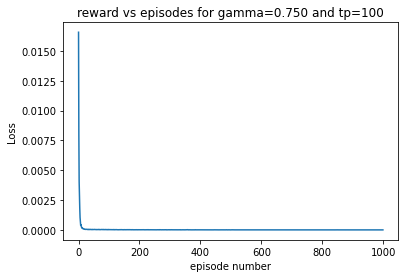

In [22]:
plt.plot(loss_list)
plt.xlabel("episode number")
plt.ylabel("Loss")
plt.title("reward vs episodes for gamma=0.750 and tp=100")
plt.show()

Text(0.5, 1.0, 'reward vs episodes for gamma=0.750 and tp=100')

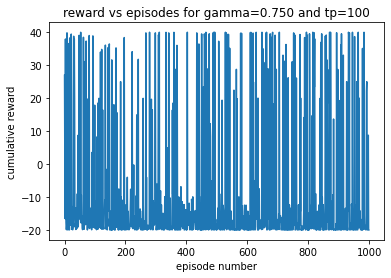

In [23]:
xs = list(range(len(rpe)))
plt.plot(xs, rpe)
plt.xlabel("episode number")
plt.ylabel("cumulative reward")
plt.title("reward vs episodes for gamma=0.750 and tp=100")
